We consider a simple fluid of particles that interact due to the Lennard Jones potential

$$
U(r) = 4\varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
$$

To validate the integration of the diffusion process and correct implementation of energies and forces, we compare observables to other known results. The observables are: the mean potential energy of the system per particle $U$,  the pressure $P$ and the radial distribution function $g(r)$.

The thermodynamic quantities of a Lennard Jones fluid are typically expressed in terms of the rescaled density
$\rho^* = (N/V)\sigma^3$ and the rescaled temperature $T^* = k_BT/\varepsilon$, where $N$ is the number of particles in the system, which is constant over time, and $V$ is the available volume.
In simulation practice we set $\sigma=1$ and $\varepsilon=1$ to achieve the reduced units. The time units are $\sigma^2 / 4D$, where $D$ is the self diffusion coefficient of the particles. Hence in practice we set the diffusion coefficient to 1 and have a fully rescaled unit system.

We use an Euler scheme to integrate the positions of particles according to the overdamped Langevin equation of motion, in contrast to a full integration of positions and momenta as in the underdamped limit.

The pressure can be measured from the acting forces according to [4].

$$
PV = Nk_BT + \langle \mathscr{W} \rangle
$$

where

$$
\mathscr{W} = \frac{1}{3} \sum_i \sum_{j>i} \mathbf{r}_{ij} \mathbf{f}_{ij},
$$

which generally works for periodic systems as well, if $r_{ij}$ is according to the minimum image convention. However the following equality

$$
\frac{1}{3} \sum_i \sum_{j>i} \mathbf{r}_{ij} \mathbf{f}_{ij} = \frac{1}{3} \sum_i \mathbf{r}_{i} \mathbf{f}_{i},
$$

cannot be used when the system is periodic because it assumes $r_{ij} = r_j - r_i$, which is not the case for particles that interact _through_ the boundaries.

__Results__

| origin | cutoff radius $r_c$ | density $\rho$ | temperature $T$ | pressure $P$ | potential energy per particle $U$ |
|---|---|---|---|---|---|
|[1]|4|0.3|3|1.023(2)|-1.673(2)|
|[2]|4|0.3|3|1.0245|-1.6717|
|HALMD [3]|4|0.3|3|1.0234(3)|-1.6731(4)|
|ReaDDy|4|0.3|3|--- *|-1.668(7)|
|||||||
|[1]|4|0.6|3|3.69(1)|-3.212(3)|
|[2]|4|0.6|3|3.7165|-3.2065|
|HALMD [3]|4|0.6|3|3.6976(8)|-3.2121(2)|
|ReaDDy|4|0.6|3|--- *|-3.200(9)|

(*) Note that the pressure cannot be measured currently.

[1] Molecular dynamics simulations, J. K. Johnson, J. A. Zollweg, and K. E. Gubbins,
The Lennard-Jones equation of state revisited, Mol. Phys. 78, 591 (1993)

[2] Integral equations theory, A. Ayadim, M. Oettel, and S Amokrane,
Optimum free energy in the reference functional approach for the integral equations theory, J. Phys.: Condens. Matter 21, 115103 (2009).

[3] HAL's MD package, http://halmd.org/validation.html

[4] Allen, M. P., & Tildesley, D. J. (1987). Computer Simulation of Liquids. New York: Oxford University Press.

In [2]:
import os
import numpy as np

import readdy

__Utility methods__

In [3]:
def average_across_first_axis(values):
    n_values = len(values)
    mean = np.sum(values, axis=0) / n_values  # shape = n_bins
    difference = values - mean  # broadcasting starts with last axis
    std_dev = np.sqrt(np.sum(difference * difference, axis=0) / n_values)
    std_err = np.sqrt(np.sum(difference * difference, axis=0) / n_values ** 2)
    return mean, std_dev, std_err


def convert_to_numpy(vlen_array):
    nt = len(vlen_array)
    nn = len(vlen_array[0])
    result = []
    for t in range(nt):
        tmp = []
        for i in range(nn):
            tmp.append([vlen_array[t][i]['x'], vlen_array[t][i]['y'], vlen_array[t][i]['z']])
        result.append(tmp)
    result = np.array(result)
    return result


def lj_system(temperature=1.):
    system = readdy.ReactionDiffusionSystem(
        box_size=[edge_length, edge_length, edge_length],
        unit_system=None
    )
    system.kbt = temperature
    system.add_species("A", diffusion_constant=1.)
    system.potentials.add_lennard_jones("A", "A", m=12, n=6, epsilon=1., sigma=1., cutoff=4., shift=True)
    return system

In [10]:
mean_energy_per_n, err_energy_per_n = dict(), dict()
mean_pressure, err_pressure = dict(), dict()
mean_rdf, err_rdf = dict(), dict()

In [4]:
density = 0.6
n_per_axis = 12
n_particles = n_per_axis ** 3
edge_length = (n_particles / density) ** (1. / 3.)
pos_x = np.linspace(-edge_length/2., edge_length/2.-1., n_per_axis)
pos = []
for x in pos_x:
    for y in pos_x:
        for z in pos_x:
            pos.append([x,y,z])
pos = np.array(pos)
print("n_particles", len(pos), "box edge_length", edge_length)
assert len(pos)==n_particles

n_particles 1728 box edge_length 14.227573217960249


In [5]:
def pos_callback(x):
    global pos
    n = len(x)
    pos = np.zeros((n,3))
    for i in range(n):
        pos[i][0] = x[i][0]
        pos[i][1] = x[i][1]
        pos[i][2] = x[i][2]
    print("saved positions")

__Define system__

In [6]:
system = lj_system(temperature=3.)

__Equilibration__

In [7]:
sim = system.simulation(kernel="SingleCPU")
sim.add_particles("A", pos)

sim.observe.particle_positions(2000, callback=pos_callback, save=None)
sim.observe.energy(500, callback=lambda x: print(x), save=None)

sim.record_trajectory(stride=1)
sim.output_file = "lj_eq.h5"
if os.path.exists(sim.output_file):
    os.remove(sim.output_file)


sim.run(n_steps=10000, timestep=1e-4)

traj = readdy.Trajectory(sim.output_file)
traj.convert_to_xyz(particle_radii={"A": 0.5})

Configured kernel context with:
--------------------------------
 - kBT = 3
 - periodic b.c. = (true, true, true)
 - box size = (14.2276, 14.2276, 14.2276)
 - particle types:
     * particle type "A" with D=1, flavor=NORMAL, id=0
 - potentials of order 2:
     * for types "A" and "A"
         * 12-6-Lennard-Jones potential with cutoff 4, epsilon 1, k 4, and with energy shift



HBox(children=(HBox(children=(Label(value='Simulation progress'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=1000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

saved positions
-6881.589189746084
-5571.949204348957
-5524.475885260745
-5648.704592208295
saved positions
-5719.957477648118
-5559.7277768366175
-5388.69641937816
-5561.500367456804
saved positions
-5528.553758527825
-5571.388644671305
-5464.756563674255
-5545.2605999942225
saved positions
-5559.886812225468
-5551.463432810196
-5464.39482059706
-5481.591312165805
saved positions
-5621.231053932005
-5576.7016395574365
-5436.4028197122625
-5575.5654718928
saved positions
-5454.225288388413


__Measure__

In [9]:
sim = system.simulation(kernel="SingleCPU")
sim.add_particles("A", pos)
sim.observe.energy(500)
sim.observe.pressure(500)
sim.observe.rdf(
    500, bin_borders=np.linspace(0.5, 4., 50),
    types_count_from="A", types_count_to="A", particle_to_density=density)

sim.output_file = "lj_measure.h5"
if os.path.exists(sim.output_file):
    os.remove(sim.output_file)

sim.run(n_steps=10000, timestep=1e-4)

Configured kernel context with:
--------------------------------
 - kBT = 3
 - periodic b.c. = (true, true, true)
 - box size = (14.2276, 14.2276, 14.2276)
 - particle types:
     * particle type "A" with D=1, flavor=NORMAL, id=0
 - potentials of order 2:
     * for types "A" and "A"
         * 12-6-Lennard-Jones potential with cutoff 4, epsilon 1, k 4, and with energy shift



HBox(children=(HBox(children=(Label(value='Simulation progress'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=1000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [11]:
traj = readdy.Trajectory(sim.output_file)
_, energy = traj.read_observable_energy()
_, bin_centers, rdf = traj.read_observable_rdf()
_, pressure = traj.read_observable_pressure()

In [12]:
mean_energy, _, err_energy = average_across_first_axis(energy) # time average
mean_energy_per_n[density] = mean_energy / n_particles
err_energy_per_n[density] = err_energy / n_particles

current_mean_pressure, _, current_err_pressure = average_across_first_axis(pressure)
mean_pressure[density] = current_mean_pressure
err_pressure[density] = current_mean_pressure

mean_rdf[density], _, err_rdf[density] = average_across_first_axis(rdf) # time average

In [13]:
current_mean_pressure

1.2248161240926976

In [14]:
current_err_pressure

0.014087489662119843

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

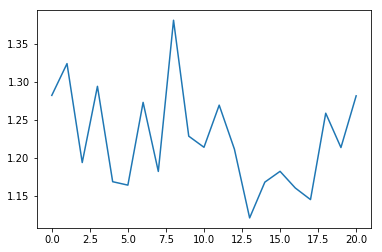

In [16]:
plt.plot(pressure)

mean energy per particle {0.3: -1.6678671765797455, 0.6: -3.1995739684456534}
err energy per particle {0.3: 0.0065533260241699481, 0.6: 0.0089460121350560928}


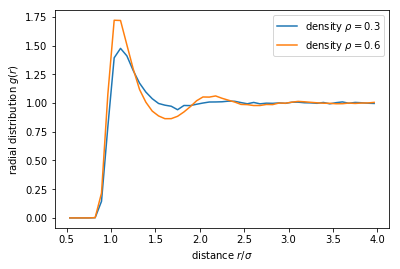

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

print("mean energy per particle {}\nerr energy per particle {}".format(mean_energy_per_n, err_energy_per_n))

for key, value in mean_rdf.items():
    plt.plot(bin_centers, value, label=r"density $\rho=" + str(key) + r"$")
plt.xlabel(r"distance $r/\sigma$")
plt.ylabel(r"radial distribution $g(r)$")
plt.legend(loc="best")
plt.show()